In [44]:
import msgspec
import pandas as pd
import numpy as np
import ast
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

# Visualizations 
from matplotlib import pyplot as plt
import seaborn as sns

# Text Preprocessing and Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import re
from wordcloud import WordCloud

### Load and Preprocess Raw Review Dataset

In [3]:
def stream_jsonl(filename):
    with open(filename, "r", encoding="utf-8") as file:
        for i, line in enumerate(file):
            yield msgspec.json.decode(line.strip())
            
# Convert streamed data to a Pandas DataFrame
review_data_raw = pd.DataFrame(stream_jsonl(
    "yelp_academic_dataset_review.json"))
print("Dataframe Shape:", review_data_raw.shape)
review_data_raw.head(3)

Dataframe Shape: (6990280, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


#### Filtering for businesses in restaurants dataset

In [4]:
restaurants = pd.read_csv('restaurants_final.csv')

In [5]:
pa_restaurant_ids = set(restaurants['business_id'])
pa_reviews = review_data_raw[review_data_raw['business_id'].isin(pa_restaurant_ids)].copy()
print("Filtered Pennsylvania Reviews Shape:", pa_reviews.shape)
pa_reviews.head(3)

Filtered Pennsylvania Reviews Shape: (836680, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25


In [6]:
pa_reviews.info()
pa_reviews.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Index: 836680 entries, 0 to 6990272
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    836680 non-null  object 
 1   user_id      836680 non-null  object 
 2   business_id  836680 non-null  object 
 3   stars        836680 non-null  float64
 4   useful       836680 non-null  int64  
 5   funny        836680 non-null  int64  
 6   cool         836680 non-null  int64  
 7   text         836680 non-null  object 
 8   date         836680 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 63.8+ MB


,stars,useful,funny,cool
count,836680.00,836680.00,836680.00,836680.00
mean,3.79,1.05,0.34,0.49
std,1.36,2.48,1.39,1.84
min,1.00,0.00,0.00,0.00
25%,3.00,0.00,0.00,0.00
50%,4.00,0.00,0.00,0.00
75%,5.00,1.00,0.00,0.00
max,5.00,224.00,227.00,163.00


In [7]:
# Change date to datetime format for describe() to work
pa_reviews['date'] = pd.to_datetime(pa_reviews['date'])
pa_reviews.info()
pa_reviews.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Index: 836680 entries, 0 to 6990272
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    836680 non-null  object        
 1   user_id      836680 non-null  object        
 2   business_id  836680 non-null  object        
 3   stars        836680 non-null  float64       
 4   useful       836680 non-null  int64         
 5   funny        836680 non-null  int64         
 6   cool         836680 non-null  int64         
 7   text         836680 non-null  object        
 8   date         836680 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 63.8+ MB


,stars,useful,funny,cool,date
count,836680.00,836680.00,836680.00,836680.00,836680
mean,3.79,1.05,0.34,0.49,2016-09-25 13:15:53.063883008
min,1.00,0.00,0.00,0.00,2005-02-16 04:06:26
25%,3.00,0.00,0.00,0.00,2014-08-01 07:33:11.500000
50%,4.00,0.00,0.00,0.00,2017-03-06 22:38:15.500000
75%,5.00,1.00,0.00,0.00,2019-04-10 12:23:19.249999872
max,5.00,224.00,227.00,163.00,2022-01-19 19:46:34
std,1.36,2.48,1.39,1.84,NaN


#### Removing user who is not present in the user dataset

#### Observation 1: Missing User Entries
After filtering, we observed that one user (user_id 'MaengE6zJ6k_d5e6nwnVaA') in the review dataset, was not found in the user dataset. His review was dated 2022-01-19, which was the maximum date in the review dataset.

In [8]:
# Convert streamed data to a Pandas DataFrame
user_data_raw = pd.DataFrame(stream_jsonl(
    "yelp_academic_dataset_user.json"))
print("Dataframe Shape:", user_data_raw.shape)
user_data_raw.head(3)

Dataframe Shape: (1987897, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18


In [9]:
valid_user_ids = set(pa_reviews['user_id'])
filtered_users = user_data_raw[user_data_raw['user_id'].isin(valid_user_ids)]

print("Filtered User Data Shape:", filtered_users.shape)
filtered_users.head(3)

Filtered User Data Shape: (269461, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
5,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,163,191,361,147,1212,5696,2543,2543,815,323


In [10]:
print("Unique Users in Review Data:", pa_reviews['user_id'].nunique())
print("Unique Users in User Data:", filtered_users['user_id'].nunique())

Unique Users in Review Data: 269462
Unique Users in User Data: 269461


In [11]:
# Find users in review dataset but not in user dataset
users_not_in_user_dataset = set(pa_reviews['user_id']) - set(user_data_raw['user_id'])

print("Number of Users in Review Dataset but Not in User Dataset:", len(users_not_in_user_dataset))
if len(users_not_in_user_dataset) > 0:
    print("Sample Missing Users:", list(users_not_in_user_dataset)[:5])

Number of Users in Review Dataset but Not in User Dataset: 1
Sample Missing Users: ['MaengE6zJ6k_d5e6nwnVaA']


In [12]:
missing_user_reviews = pa_reviews[pa_reviews['user_id'].isin(users_not_in_user_dataset)]
missing_user_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
2076660,GZmjLeVfDktqx7xZvAHBSg,MaengE6zJ6k_d5e6nwnVaA,kZTwub3IkBCDHYW5J5pRrA,1.0,0,0,0,Ordered 2 meatball park sandwiches both sandwi...,2022-01-19 17:45:25


With this, we conducted a deeper analysis of the raw review and user datasets and found that 32 users who made their first review on 2022-01-19 were missing from the review dataset. This suggests that the user dataset was retrieved earlier than the review dataset, thus new user activities that are being captured in the review dataset are not shown in the user dataset.

In [13]:
all_missing_users = set(review_data_raw['user_id']) - set(user_data_raw['user_id'])
print("All missing users:", len(all_missing_users))
if len(all_missing_users) > 0:
    print("Sample Missing Users:", list(all_missing_users)[:5])

All missing users: 32
Sample Missing Users: ['4bqSo-Xfd8Yu5BMDsd947Q', 'u8cq-5zzD7dPSa3LR8rIMw', '77n3enAMdlka0pZ82GT9VQ', 'I6G8wz_LD_8IsCPxvjs8SQ', 'G0PWeUgNeGDobntevJlJ1g']


In [16]:
all_missing_user_reviews = review_data_raw[review_data_raw['user_id'].isin(all_missing_users)].copy()
print('Number of missing user reviews: ', len(all_missing_user_reviews))

Number of missing user reviews:  33


### Additional Processing for Review Dataset
After filtering both datasets, only the above-mentioned user (user_id 'MaengE6zJ6k_d5e6nwnVaA') remained problematic. Hence, further filtering was done on the review dataset to drop this user, ensuring consistency across the review and user datasets.

In [17]:
# Drop users in users_not_in_user_dataset from pa_reviews
pa_reviews_filtered = pa_reviews[~pa_reviews['user_id'].isin(users_not_in_user_dataset)]
print("Dataframe Shape:", pa_reviews_filtered.shape)
pa_reviews_filtered.head(3)

Dataframe Shape: (836679, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25


#### Observation 2: Mismatch review_count
We found that 55 users in the filtered user dataset had a review_count of 0, even though they posted reviews and are present in the raw review dataset. This inconsistency further emphasizes that the review and user datasets were extracted at different dates/times, leading to a mismatch in their recorded review_count. 

In [19]:
dataset_users_with_zero_reviews = user_data_raw[user_data_raw['review_count'] == 0]

print("Users with zero reviews Dataset Shape:", dataset_users_with_zero_reviews.shape)
dataset_users_with_zero_reviews.head(2)

Users with zero reviews Dataset Shape: (54, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
81766,1zEwvAm5TqJh7eqYShNVQA,Amy,0,2012-12-29 20:14:47,0,0,0,,"Ipy8IeeWpzp8TsgFpFg1fA, oRTkkL_IAnI1phwsWpjr1g...",0,...,0,0,0,0,0,0,0,0,0,0
146673,T8qn_FUg24LsdPaax4plNA,Kevin,0,2012-09-15 06:28:28,5,1,0,,None,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Find reviews of users who have 0 review count in the raw user dataset
users_with_zero_reviews = user_data_raw[user_data_raw['review_count'] == 0]['user_id']
reviews_from_zero_review_users = review_data_raw[review_data_raw['user_id'].isin(users_with_zero_reviews)].copy()

print("Reviews from Users with 0 Review Count in User Dataset Shape:", reviews_from_zero_review_users.shape)
reviews_from_zero_review_users.head(2)

Reviews from Users with 0 Review Count in User Dataset Shape: (55, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
186528,yVGPMkh_VIBcQ7COR-4nmA,1zEwvAm5TqJh7eqYShNVQA,S2Ho8yLxhKAa26pBAm6rxA,4.0,0,0,0,Great food and service! Perfect lunch by the W...,2015-12-28 17:55:42
212386,1b8HbWqbxXJArVaEMqyEBw,T8qn_FUg24LsdPaax4plNA,j99PtxlKTW_u5alE4jiqHQ,1.0,5,1,0,Unbelievably horrible experience! I can't beli...,2015-06-14 03:19:50


In [23]:
number_reviews_from_zero_review_users = reviews_from_zero_review_users['user_id'].nunique()
print('Number of reviews from user who is labeled as 0 review count:', number_reviews_from_zero_review_users)

Number of reviews from user who is labeled as 0 review count: 54


After filtering both datasets, only 5 of such users remained. When cross-checking their review and user attributes (Figures 5 and 6), we noticed that although the review_count field was incorrect for these users, other user attributes (e.g., average_stars, useful, funny, cool votes) remained accurate. Hence, we left them in the user dataset.

In [24]:
filtered_users_with_zero_reviews = filtered_users[filtered_users['review_count'] == 0]
print(filtered_users_with_zero_reviews.shape)
filtered_users_with_zero_reviews.head(2)

(5, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
146673,T8qn_FUg24LsdPaax4plNA,Kevin,0,2012-09-15 06:28:28,5,1,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1144789,909VYxYlC3ZZMaeDcZWmzw,Michael,0,2021-12-04 02:55:06,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
reviews_of_zero_review_users = pa_reviews_filtered[pa_reviews_filtered['user_id'].isin(filtered_users_with_zero_reviews['user_id'])]
print(reviews_of_zero_review_users.shape)
reviews_of_zero_review_users.head(2)

(5, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
212386,1b8HbWqbxXJArVaEMqyEBw,T8qn_FUg24LsdPaax4plNA,j99PtxlKTW_u5alE4jiqHQ,1.0,5,1,0,Unbelievably horrible experience! I can't beli...,2015-06-14 03:19:50
2648676,fpN-pTX3Y_OsnkD36G7ycA,909VYxYlC3ZZMaeDcZWmzw,u50hTvPV_W_Hx625ytvLYw,5.0,0,0,0,This place has the best food in town! The deli...,2022-01-19 19:27:53


### Feature Engineering (Review Dataset)

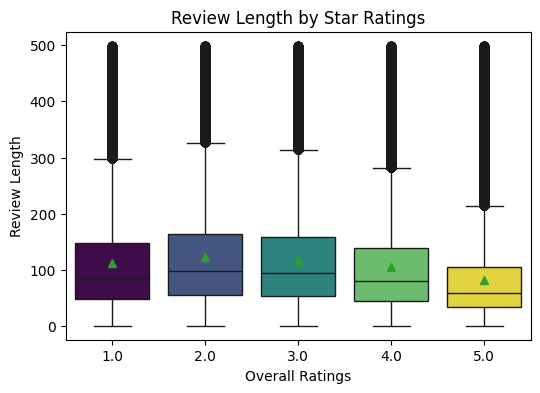

In [27]:
df_r = pa_reviews_filtered.copy()

df_r['text_length'] = df_r['text'].apply(lambda x: len(x.split(" ")))

df_r_temporary = df_r[df_r['text_length'] < 500].copy()

plt.figure(figsize=(6, 4))
sns.boxplot(x='stars', y='text_length', data=df_r_temporary, hue='stars',
            showmeans=True, palette='viridis', legend=False)
plt.title('Review Length by Star Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Review Length')

plt.show()

In [28]:
print("With review text length:", df_r.shape)
df_r.head(3)

With review text length: (836679, 10)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42


#### Processed Review Text

In [32]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/sinhyejin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sinhyejin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sinhyejin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sinhyejin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [35]:
### processed_review
def process_text(text):
    # Convert to Lowercase (0.1 marks)
    text_lower = text.lower()

    # Tokenization (0.1 marks)
    tokens = word_tokenize(text_lower)

    # Filter Alphabetic Tokens (0.1 marks)
    alphabetic_tokens = [word for word in tokens if re.match('^[a-zA-Z]+$', word)]

    # Remove Stopwords and Negation Words
    stop_words = set(stopwords.words('english'))
    # Negation words that should not be removed (0.1 marks)
    negation_words = ['not', 'no', 'never', "n't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
                      "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "cannot"]
    # Create a list of tokens without stopwords and preserving negation words
    tokens_no_stopwords = [word for word in alphabetic_tokens if ((word not in stop_words) or (word in negation_words))]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    # Apply lemmatization to each token (0.1 marks)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]

    # Join the lemmatized tokens into a single processed text (0.1 marks)
    processed_text = ' '.join(lemmatized_words)

    return processed_text


In [36]:
df_r['processed_review'] = df_r['text'].apply(process_text)
print("With processed review:", df_r.shape)
df_r.head(3)

With processed review: (836679, 11)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...


In [37]:
# Download NLTK resources for part-of-speech tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Define function to extract adjectives
def extract_adjectives(text):
    """
    Extracts adjectives from a given text.

    Parameters:
    - text (str): The input text from which adjectives will be extracted.

    Returns:
    - list: A list of adjectives extracted from the input text.
    """

    # Tokenize the input text
    tokens = word_tokenize(text)

    # Perform part-of-speech tagging on the tokens
    pos_tags = pos_tag(tokens) # (0.1 marks)

    # Extract adjectives based on their part-of-speech tags
    adjectives = [word for word, pos in pos_tags if pos in ["JJ"]] # (0.1 marks)

    # Return the list of extracted adjectives
    return adjectives

[nltk_data] Downloading package punkt to /Users/sinhyejin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sinhyejin/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [38]:
# Define function to generate Word Cloud for adjectives
def generate_word_cloud_adjectives(text, title):
    """
    Generates a Word Cloud visualization for adjectives extracted from the input text.

    Parameters:
    - text (str): The input text from which adjectives will be extracted and visualized.

    Returns:
    - None: Displays the generated Word Cloud plot.
    """

    # Extract adjectives using the previously defined extract_adjectives function
    adjectives = extract_adjectives(text)

    # Create a WordCloud object with specific configurations (0.1 marks)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(adjectives))

    # Plot the Word Cloud (0.1 marks)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [39]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sinhyejin/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [41]:
low_star_reviews = " ".join(df_r[df_r['stars'] < 3]['processed_review'])
high_star_reviews = " ".join(df_r[df_r['stars'] > 3]['processed_review'])

# Generate Word Clouds for adjectives in low and high star reviews (0.1 marks)
# generate_word_cloud_adjectives(low_star_reviews, "Word Cloud for Low Star Ratings")
# generate_word_cloud_adjectives(high_star_reviews, "Word Cloud for High Star Ratings")

#### Sum of votes for each review

In [42]:
df_r['sum_votes'] = df_r[['funny', 'useful', 'cool']].fillna(0).sum(axis=1)
print("With sum_votes:", df_r.shape)
df_r.head(3)

With sum_votes: (836679, 12)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...,0


#### Decay Factor and Weighted Reviews

In [45]:
# Compute review age in days
baseline_date = datetime(2025, 1, 1)
df_r['review_age_days'] = (baseline_date - pd.to_datetime(df_r['date'])).dt.days

# Function to apply time decay
def apply_time_decay(df, decay_factor):
    df = df.copy()
    df.loc[:, 'review_weight'] = np.exp(-df['review_age_days'] / decay_factor)
    df.loc[:, 'weighted_stars'] = df['stars'] * df['review_weight']
    return df

# Split data into 80% train, 20% test
train_data, test_data = train_test_split(df_r, test_size=0.2, random_state=42)

# Cross-validation with 80% training data using decay factors in multiples of 365
decay_factors = [365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650, 4015, 4380, 4745, 5110, 5475, 5840, 6205, 6570, 6935, 7000]
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for decay in decay_factors:
    mse_scores = []
    
    for train_index, val_index in kf.split(train_data):
        train_df, val_df = train_data.iloc[train_index].copy(), train_data.iloc[val_index].copy()
        
        # Apply time decay
        train_df = apply_time_decay(train_df, decay)
        val_df = apply_time_decay(val_df, decay)
        
        # Compute mean weighted rating per business
        business_avg_weighted_rating = train_df.groupby('business_id')['weighted_stars'].mean().fillna(0)
        
        # Predict validation ratings using the business averages
        val_df.loc[:, 'predicted_rating'] = val_df['business_id'].map(business_avg_weighted_rating).fillna(3)
        
        # Compute MSE
        mse = mean_squared_error(val_df['stars'], val_df['predicted_rating'])
        mse_scores.append(mse)
    
    # Store average MSE for this decay factor
    cv_results[decay] = np.mean(mse_scores)

# Find the best decay factor
best_decay = min(cv_results, key=cv_results.get)
print("Best Decay Factor:", best_decay)
print("Cross-validation MSE Scores:", cv_results)

# Apply the best decay factor to the dataset
df_r = apply_time_decay(df_r.copy(), best_decay)

Best Decay Factor: 7000
Cross-validation MSE Scores: {365: 16.0900634117175, 730: 15.018418645035414, 1095: 13.37725684400526, 1460: 11.721075114096099, 1825: 10.256569624112808, 2190: 9.022524188277927, 2555: 7.999868441118966, 2920: 7.155107471976992, 3285: 6.455278685652533, 3650: 5.872228250232003, 4015: 5.383144211371575, 4380: 4.969923501309356, 4745: 4.61829579919536, 5110: 4.317009688085525, 5475: 4.057160629612624, 5840: 3.8316620158876247, 6205: 3.634837408376575, 6570: 3.4621087144883864, 6935: 3.309758060544037, 7000: 3.284524107543247}


In [46]:
print("With time decay etc:", df_r.shape)
df_r.head(3)

With time decay etc: (836679, 15)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes,review_age_days,review_weight,weighted_stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0,2369,0.712890,2.138669
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2,3649,0.593757,2.968783
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...,0,4208,0.548185,2.740924


In [47]:
df_r.to_csv('review_final.csv', index=False)
filtered_users.to_csv("filtered_users.csv", index=False)